In [ ]:
%pip install catboost

     |████████████████████████████████| 64.4MB 60kB/s 


In [ ]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
#import catboost as cb
import xgboost as xgb
from google.colab import files

In [ ]:
np.random.seed(1)
# Quantile to Estimate
alpha = 0.90
# Training data size
N_DATA = 10000
# Function to Estimate
def f(x):
    """The function to predict."""
    return 30+x * np.sin(x)

# model parameters
LEARNING_RATE = 0.1
N_ESTIMATORS = 100
NUM_LEAVES = 8 # lgbm only
MAX_DEPTH = 3
MIN_DATA = 9

#---------------------- DATA GENERATION ------------------- #

#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=N_DATA)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 9999)).T
xx = xx.astype(np.float32)

In [ ]:
dy

array([2.26549696, 1.80817277, 2.23537788, ..., 1.54518896, 2.19652811,
       1.79964274])

In [ ]:
# ------------------- PLOTTING ----------------- #
def plot_predictions(y, y_pred, y_upper, y_lower, y_autohigh, y_autolow, figname=None):
  frac_below_upper = round(np.count_nonzero(y_autohigh > y) / len(y),3)
  frac_above_upper = round(np.count_nonzero(y_autohigh < y) / len(y),3)
  frac_above_lower = round(np.count_nonzero(y_autolow < y) / len(y),3)
  frac_below_lower = round(np.count_nonzero(y_autolow > y) / len(y),3)

  # Print calibration test
  print('fraction below upper estimate: \t actual: ' + str(frac_below_upper) + '\t ideal: ' + str(alpha))
  print('fraction above lower estimate: \t actual: ' + str(frac_above_lower) + '\t ideal: ' + str(alpha))

  plt.figure(figsize=(10,5))
  #plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
  plt.plot(X, y, 'b.', markersize=3)#, label=u'Observations')
  plt.plot(xx, y_pred, 'r-')#, label=u'Mean Prediction')
  plt.plot(xx, y_upper, 'k-')
  plt.plot(xx, y_lower, 'k-')
  plt.fill(np.concatenate([xx, xx[::-1]]),
              np.concatenate([y_upper, y_lower[::-1]]),
              alpha=.5, fc='b', ec='None', label=(str(round(100*(alpha-0.5)*2))+'% prediction interval'))
  plt.scatter(x=X[y_autohigh < y], y=y[y_autohigh < y], s=20, marker='x', c = 'red', 
          label = str(round(100*frac_above_upper,1))+'% of training data above upper (expect '+str(round(100*(1-alpha),1))+'%)')
  plt.scatter(x=X[y_autolow > y], y=y[y_autolow > y], s=20, marker='x', c = 'orange', 
          label = str(round(100*frac_below_lower,1))+ '% of training data below lower (expect '+str(round(100*(1-alpha),1))+'%)')
  plt.xlabel('$x$', fontsize=15)
  plt.ylabel('$f(x)$', fontsize=15)
  plt.legend(loc='upper left')
  plt.title(  '  Alpha: '+str(alpha) +
              '  N_est: '+str(N_ESTIMATORS) +
              '  L_rate: '+str(LEARNING_RATE) +
              '  Max_depth: '+str(MAX_DEPTH), fontsize=15)

  plt.show()
  
  if figname: 
    plt.savefig(figname)
    files.download(figname)

# **Sci-kit learn GBM Quantile**

In [ ]:
N_ESTIMATORS = 1000
init = 'zero'
# Train high, low, and mean regressors.
# ------------------- HIGH/UPPER BOUND ------------------- #
clfh = GradientBoostingRegressor(loss='quantile', alpha=alpha,
            n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,
            learning_rate=LEARNING_RATE, min_samples_leaf=MIN_DATA,
            min_samples_split=MIN_DATA, init=init)
clfh.fit(X, y)
# ------------------- LOW/LOWER BOUND ------------------- #
clfl = GradientBoostingRegressor(loss='quantile', alpha=1.0-alpha,
    n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,
    learning_rate=LEARNING_RATE, min_samples_leaf=MIN_DATA,
    min_samples_split=MIN_DATA, init=init)
clfl.fit(X, y)
# ------------------- MEAN/PREDICTION ------------------- #
clf = GradientBoostingRegressor(loss='lad',
        n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH,
        learning_rate=LEARNING_RATE, min_samples_leaf=MIN_DATA,
        min_samples_split=MIN_DATA, init=init)
clf.fit(X, y)
# ---------------- PREDICTING ----------------- #

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)
y_lower = clfl.predict(xx)
y_upper = clfh.predict(xx)

# Check calibration by predicting the training data.
y_autopred = clf.predict(X)
y_autolow = clfl.predict(X)
y_autohigh = clfh.predict(X)

fraction below upper estimate: 	 actual: 0.9	 ideal: 0.9
fraction above lower estimate: 	 actual: 0.9	 ideal: 0.9


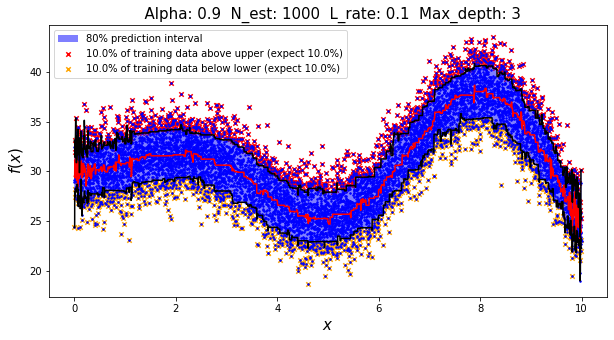

In [ ]:
plot_predictions(y, y_pred, y_upper, y_lower, y_autohigh, y_autolow)

# **LightGBM Quantile**

### **Implemented method**

In [ ]:
N_ESTIMATORS = 1000
BOOST_FROM_AVERAGE = True
# ------------------- HIGH/UPPER BOUND ------------------- #
clfh = lgb.LGBMRegressor(objective = 'quantile',
                        alpha = alpha,
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        max_depth = MAX_DEPTH,
                        min_data = MIN_DATA,
                        boost_from_average=BOOST_FROM_AVERAGE)
clfh.fit(X, y)
# ------------------- LOW/LOWER BOUND ------------------- #
clfl = lgb.LGBMRegressor(objective = 'quantile',
                        alpha = 1.0 - alpha,
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        max_depth = MAX_DEPTH,
                        min_data = MIN_DATA,
                        boost_from_average=BOOST_FROM_AVERAGE)

clfl.fit(X, y)
# ------------------- MEAN/PREDICTION ------------------- #
clf = lgb.LGBMRegressor(objective = 'regression_l1',
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        max_depth = MAX_DEPTH,
                        min_data = MIN_DATA,
                        boost_from_average=BOOST_FROM_AVERAGE)

clf.fit(X, y)
# ---------------- PREDICTING ----------------- #

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)
y_lower = clfl.predict(xx)
y_upper = clfh.predict(xx)

# Check calibration by predicting the training data.
y_autopred = clf.predict(X)
y_autolow = clfl.predict(X)
y_autohigh = clfh.predict(X)

fraction below upper estimate: 	 actual: 0.901	 ideal: 0.9
fraction above lower estimate: 	 actual: 0.899	 ideal: 0.9


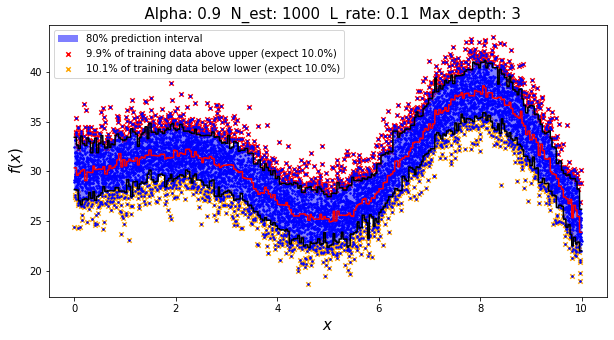

In [ ]:
plot_predictions(y, y_pred, y_upper, y_lower, y_autohigh, y_autolow)

### **Naive method**

In [ ]:
def quantile_loss_lgb_alpha(y_true, y_pred):
    residual = (y_pred - y_true).astype("float")
    grad = np.where(residual<0, -0.9, 1-0.9)
    hess = np.where(residual<0, 1.0, 1.0)
    return grad, hess
def quantile_loss_lgb_1alpha(y_true, y_pred):
    residual = (y_pred - y_true).astype("float")
    grad = np.where(residual<0, -0.1, 1-0.1)
    hess = np.where(residual<0, 1.0, 1.0)
    return grad, hess
def quantile_loss_lgb_median(y_true, y_pred):
    residual = (y_pred - y_true).astype("float")
    grad = np.where(residual<0, -0.5, 1-0.5)
    hess = np.where(residual<0, 1.0, 1.0)
    return grad, hess

In [ ]:
N_ESTIMATORS = 1000
BOOST_FROM_AVERAGE = True
# ------------------- HIGH/UPPER BOUND ------------------- #
clfh = lgb.LGBMRegressor(objective=quantile_loss_lgb_alpha,
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        max_depth = MAX_DEPTH,
                        min_data = MIN_DATA,
                         boost_from_average=BOOST_FROM_AVERAGE
                         )
clfh.fit(X, y)
# ------------------- LOW/LOWER BOUND ------------------- #
clfl = lgb.LGBMRegressor(objective = quantile_loss_lgb_1alpha,
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        max_depth = MAX_DEPTH,
                         boost_from_average=BOOST_FROM_AVERAGE,
                        min_data = MIN_DATA)
clfl.fit(X, y)
# ------------------- MEAN/PREDICTION ------------------- #
clf = lgb.LGBMRegressor(objective = quantile_loss_lgb_median,
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        max_depth = MAX_DEPTH,
                        boost_from_average=BOOST_FROM_AVERAGE,
                        min_data = MIN_DATA)
clf.fit(X, y)
# ---------------- PREDICTING ----------------- #

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)
y_lower = clfl.predict(xx)
y_upper = clfh.predict(xx)

# Check calibration by predicting the training data.
y_autopred = clf.predict(X)
y_autolow = clfl.predict(X)
y_autohigh = clfh.predict(X)

fraction below upper estimate: 	 actual: 0.9	 ideal: 0.9
fraction above lower estimate: 	 actual: 0.9	 ideal: 0.9


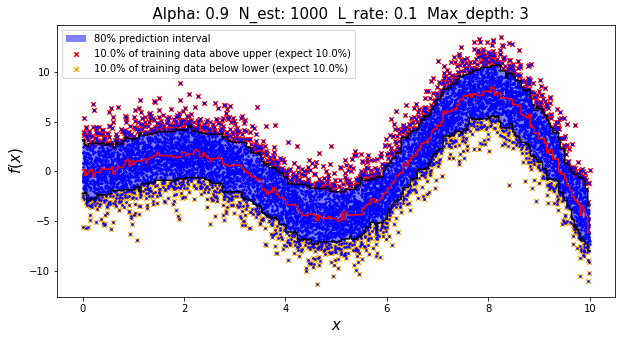

In [ ]:
plot_predictions(y, y_pred, y_upper, y_lower, y_autohigh, y_autolow)

# **CatBoost Quantile**

### **Preimplemented version**

In [ ]:
LEAF_ESTIMATION_METHOD = 'Gradient' # Exact, Gradient or Newton
N_ESTIMATORS = 10
# ------------------- HIGH/UPPER BOUND ------------------- #
clfh = cb.CatBoostRegressor(objective = 'Quantile:alpha='+str(alpha),
                            num_leaves = NUM_LEAVES,
                            learning_rate = LEARNING_RATE,
                            n_estimators = N_ESTIMATORS,
                            max_depth = MAX_DEPTH,
                            min_data_in_leaf = MIN_DATA,
                            leaf_estimation_method = LEAF_ESTIMATION_METHOD,
                            verbose = False)
clfh.fit(X, y)
# ------------------- LOW/LOWER BOUND ------------------- #
clfl = cb.CatBoostRegressor(objective = 'Quantile:alpha='+str(1.0-alpha),
                            num_leaves = NUM_LEAVES,
                            learning_rate = LEARNING_RATE,
                            n_estimators = N_ESTIMATORS,
                            max_depth = MAX_DEPTH,
                            min_data_in_leaf = MIN_DATA,
                            leaf_estimation_method = LEAF_ESTIMATION_METHOD,
                            verbose = False)
clfl.fit(X, y)
# ------------------- MEAN/PREDICTION ------------------- #
clf = cb.CatBoostRegressor(objective = 'MAE',
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        max_depth = MAX_DEPTH,
                        min_data_in_leaf = MIN_DATA,
                        leaf_estimation_method = LEAF_ESTIMATION_METHOD,
                        verbose = False)
clf.fit(X, y)
# ---------------- PREDICTING ----------------- #

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)
y_lower = clfl.predict(xx)
y_upper = clfh.predict(xx)

# Check calibration by predicting the training data.
y_autopred = clf.predict(X)
y_autolow = clfl.predict(X)
y_autohigh = clfh.predict(X)

fraction below upper estimate: 	 actual: 0.911	 ideal: 0.9
fraction above lower estimate: 	 actual: 0.91	 ideal: 0.9


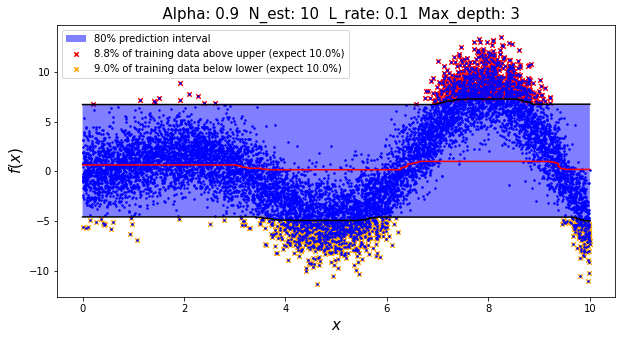

In [ ]:
plot_predictions(y, y_pred, y_upper, y_lower, y_autohigh, y_autolow)

### **Changing the starting point**

In [ ]:
BOOST_FROM_AVERAGE = False
LEAF_ESTIMATION_METHOD = 'Gradient' # Exact, Gradient or Newton
N_ESTIMATORS = 100
# ------------------- HIGH/UPPER BOUND ------------------- #
clfh = cb.CatBoostRegressor(objective = 'Quantile:alpha='+str(alpha),
                            num_leaves = NUM_LEAVES,
                            learning_rate = LEARNING_RATE,
                            n_estimators = N_ESTIMATORS,
                            max_depth = MAX_DEPTH,
                            min_data_in_leaf = MIN_DATA,
                            leaf_estimation_method = LEAF_ESTIMATION_METHOD,
                            boost_from_average=BOOST_FROM_AVERAGE,
                            verbose = False)
clfh.fit(X, y)
# ------------------- LOW/LOWER BOUND ------------------- #
clfl = cb.CatBoostRegressor(objective = 'Quantile:alpha='+str(1.0-alpha),
                            num_leaves = NUM_LEAVES,
                            learning_rate = LEARNING_RATE,
                            n_estimators = N_ESTIMATORS,
                            max_depth = MAX_DEPTH,
                            min_data_in_leaf = MIN_DATA,
                            leaf_estimation_method = LEAF_ESTIMATION_METHOD,
                            boost_from_average=BOOST_FROM_AVERAGE,
                            verbose = False)
clfl.fit(X, y)
# ------------------- MEAN/PREDICTION ------------------- #
clf = cb.CatBoostRegressor(objective = 'MAE',
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        max_depth = MAX_DEPTH,
                        min_data_in_leaf = MIN_DATA,
                        leaf_estimation_method = LEAF_ESTIMATION_METHOD,
                        boost_from_average=BOOST_FROM_AVERAGE,
                        verbose = False)
clf.fit(X, y)
# ---------------- PREDICTING ----------------- #

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)
y_lower = clfl.predict(xx)
y_upper = clfh.predict(xx)

# Check calibration by predicting the training data.
y_autopred = clf.predict(X)
y_autolow = clfl.predict(X)
y_autohigh = clfh.predict(X)

fraction below upper estimate: 	 actual: 0.775	 ideal: 0.9
fraction above lower estimate: 	 actual: 0.831	 ideal: 0.9


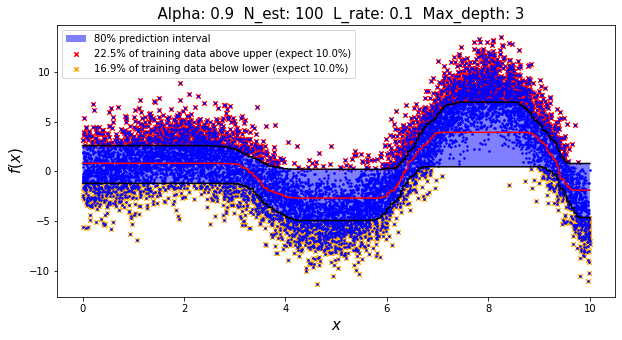

In [ ]:
plot_predictions(y, y_pred, y_upper, y_lower, y_autohigh, y_autolow)

### **Naive version** 

In [ ]:
class catboost_quantile_loss(object):
      
    def __init__(self, alpha):
      self.alpha=alpha
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)

        result = []
        for index in range(len(targets)):
            error = approxes[index] - targets[index]
            der1 = -self.alpha if error<0 else 1-self.alpha
            der2 = 1
            result.append((der1, der2))

        return result

In [ ]:
#BASELINE_alpha = np.quantile(y, alpha)
#BASELINE_1alpha = np.quantile(y, 1-alpha)
#BASELINE_median = np.quantile(y, 0.5)

BASELINE_alpha = np.array(0)
BASELINE_1alpha = np.array(0)
BASELINE_median = np.array(0)
LEAF_ESTIMATION_METHOD = 'Gradient' # Exact, Gradient or Newton
N_ESTIMATORS = 1000
# ------------------- HIGH/UPPER BOUND ------------------- #
clfh = cb.CatBoostRegressor(num_leaves = NUM_LEAVES,
                            learning_rate = LEARNING_RATE,
                            n_estimators = N_ESTIMATORS,
                            max_depth = MAX_DEPTH,
                            min_data_in_leaf = MIN_DATA,
                            loss_function=catboost_quantile_loss(alpha),
                            eval_metric='MAE',
                            verbose = False)
clfh.fit(X, y, baseline=BASELINE_alpha.repeat(len(y)))
# ------------------- LOW/LOWER BOUND ------------------- #
clfl = cb.CatBoostRegressor(num_leaves = NUM_LEAVES,
                            learning_rate = LEARNING_RATE,
                            n_estimators = N_ESTIMATORS,
                            max_depth = MAX_DEPTH,
                            min_data_in_leaf = MIN_DATA,
                            loss_function=catboost_quantile_loss(1.0-alpha),
                            eval_metric='MAE',
                            verbose = False)
clfl.fit(X, y, baseline=BASELINE_1alpha.repeat(len(y)))
# ------------------- MEAN/PREDICTION ------------------- #
clf = cb.CatBoostRegressor(num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        max_depth = MAX_DEPTH,
                        min_data_in_leaf = MIN_DATA,
                        loss_function=catboost_quantile_loss(0.5),
                        eval_metric='MAE',
                        verbose = False)
clf.fit(X, y, baseline=BASELINE_median.repeat(len(y)))
# ---------------- PREDICTING ----------------- #

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)+BASELINE_median
y_lower = clfl.predict(xx)+BASELINE_1alpha
y_upper = clfh.predict(xx)+BASELINE_alpha

# Check calibration by predicting the training data.
y_autopred = clf.predict(X)+BASELINE_median
y_autolow = clfl.predict(X)+BASELINE_1alpha
y_autohigh = clfh.predict(X)+BASELINE_alpha

fraction below upper estimate: 	 actual: 0.9	 ideal: 0.9
fraction above lower estimate: 	 actual: 0.901	 ideal: 0.9


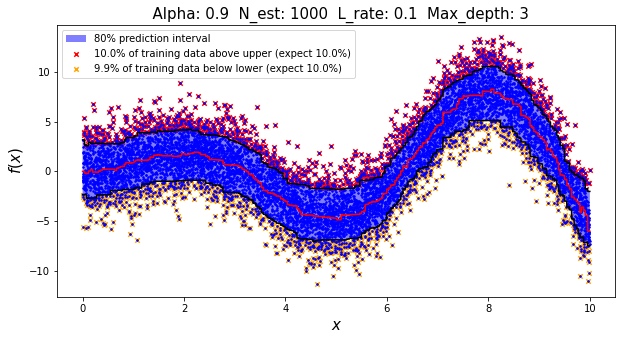

In [ ]:
plot_predictions(y, y_pred, y_upper, y_lower, y_autohigh, y_autolow)

# **XGBoost Quantile**

In [ ]:
def xgb_quantile_obj(preds, labels, quantile=0.2):
    """
    Computes first-order derivative of quantile
    regression loss and a non-degenerate
    substitute for second-order derivative.
    Substitute is returned instead of zeros,
    because XGBoost requires non-zero
    second-order derivatives. See this page:
    https://github.com/dmlc/xgboost/issues/1825
    to see why it is possible to use this trick.
    However, be sure that hyperparameter named
    `max_delta_step` is small enough to satisfy:
    ```0.5 * max_delta_step <=
       min(quantile, 1 - quantile)```.
    @type preds: numpy.ndarray
    @type dmatrix: xgboost.DMatrix
    @type quantile: float
    @rtype: tuple(numpy.ndarray)
    """
    try:
        assert 0 <= quantile <= 1
    except AssertionError:
        raise ValueError("Quantile value must be float between 0 and 1.")

    labels = labels.get_label()
    errors = preds-labels
    #errors = labels-preds

    left_mask = errors < 0
    right_mask = errors > 0

    grad = -quantile * left_mask + (1 - quantile) * right_mask
    hess = np.ones_like(preds)

    return grad, hess

In [ ]:
def rmsle(predt, dtrain):
    #y = dtrain.get_label()
    y = dtrain
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

In [ ]:
def evalerror(preds, labels, quantile=0.2):

    try:
        assert 0 <= quantile <= 1
    except AssertionError:
        raise ValueError("Quantile value must be float between 0 and 1.")

    labels = labels.get_label()
    errors = preds-labels
    #errors = labels-preds

    left_mask = errors < 0
    right_mask = errors > 0

    loss = (-quantile * left_mask + (1 - quantile) * right_mask)*errors

    # return a pair metric_name, result. The metric name must not contain a
    # colon (:) or a space since preds are margin(before logistic
    # transformation, cutoff at 0)
    return 'my-error', float(loss.mean())

In [ ]:
LEARNING_RATE = 0.1
N_ESTIMATORS = 10
# ------------------- HIGH/UPPER BOUND ------------------- #
clfh = xgb.XGBRFRegressor(objective = partial(xgb_quantile_obj, quantile=alpha),
                            num_leaves = NUM_LEAVES,
                            learning_rate = LEARNING_RATE,
                            n_estimators = N_ESTIMATORS,
                            max_depth = MAX_DEPTH,
                            min_data_in_leaf = MIN_DATA,
                          eval_metric=rmsle,
                            verbose = False)
clfh.fit(X, y)#, early_stopping_rounds=0)
# ------------------- LOW/LOWER BOUND ------------------- #
clfl = xgb.XGBRFRegressor(objective = partial(xgb_quantile_obj, quantile=1.0-alpha),
                            num_leaves = NUM_LEAVES,
                            learning_rate = LEARNING_RATE,
                            n_estimators = N_ESTIMATORS,
                            max_depth = MAX_DEPTH,
                            min_data_in_leaf = MIN_DATA,
                            verbose = False)
clfl.fit(X, y)
# ------------------- MEAN/PREDICTION ------------------- #
clf = xgb.XGBRFRegressor(objective = partial(xgb_quantile_obj, quantile=0.5),
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        max_depth = MAX_DEPTH,
                        min_data_in_leaf = MIN_DATA,
                        verbose = False)
clf.fit(X, y)
# ---------------- PREDICTING ----------------- #

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)
y_lower = clfl.predict(xx)
y_upper = clfh.predict(xx)

# Check calibration by predicting the training data.
y_autopred = clf.predict(X)
y_autolow = clfl.predict(X)
y_autohigh = clfh.predict(X)

XGBoostError: ignored

In [ ]:
y_upper

array([0.53144205, 0.53144205, 0.53144205, ..., 0.49151075, 0.49151075,
       0.49151075], dtype=float32)

fraction below upper estimate: 	 actual: 0.9	 ideal: 0.9
fraction above lower estimate: 	 actual: 0.901	 ideal: 0.9


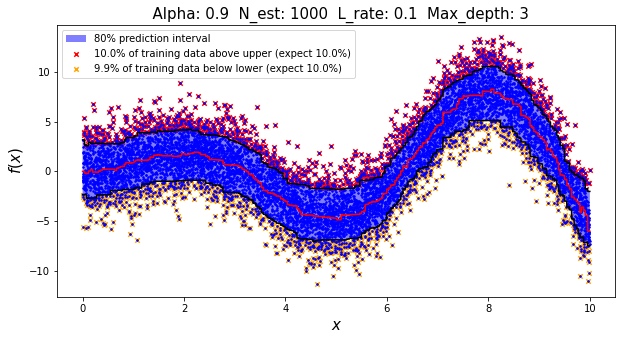

In [ ]:
plot_predictions(y, y_pred, y_upper, y_lower, y_autohigh, y_autolow)

In [ ]:
N_ESTIMATORS = 10
evals_result_xgb = {}

train = xgb.DMatrix(X, label=y)
evals = [(train, 'train')]#, (test_set['xgboost'], 'test')]

# ------------------- HIGH/UPPER BOUND ------------------- #
clfh = xgb.train({'eta': LEARNING_RATE,
                              'max_depth': MAX_DEPTH,
                              'min_data': MIN_DATA},
    train, N_ESTIMATORS, obj = partial(xgb_quantile_obj, quantile=alpha))
# ------------------- LOW/LOWER BOUND ------------------- #
clfl = xgb.train({'eta': LEARNING_RATE,
                              'max_depth': MAX_DEPTH,
                              'min_data': MIN_DATA},
    train, N_ESTIMATORS, obj = partial(xgb_quantile_obj, quantile=1.0-alpha))
# ------------------- MEAN/PREDICTION ------------------- #
clf = xgb.train({'eta': LEARNING_RATE,
                'max_depth': MAX_DEPTH,
                'min_data': MIN_DATA},
                train, N_ESTIMATORS,
                obj = partial(xgb_quantile_obj, quantile=0.5))
# ---------------- PREDICTING ----------------- #

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xgb.DMatrix(xx))
y_lower = clfl.predict(xgb.DMatrix(xx))
y_upper = clfh.predict(xgb.DMatrix(xx))

# Check calibration by predicting the training data.
y_autopred = clf.predict(xgb.DMatrix(X))
y_autolow = clfl.predict(xgb.DMatrix(X))
y_autohigh = clfh.predict(xgb.DMatrix(X))

fraction below upper estimate: 	 actual: 0.0	 ideal: 0.9
fraction above lower estimate: 	 actual: 1.0	 ideal: 0.9


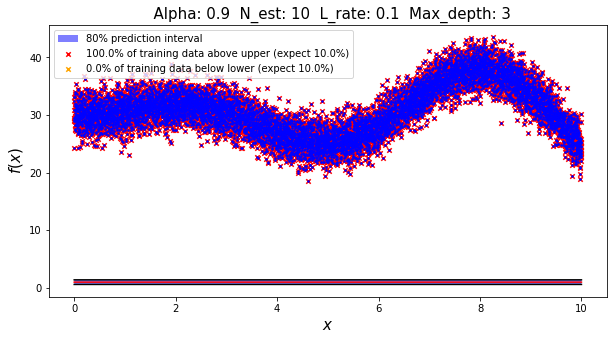

In [ ]:
plot_predictions(y, y_pred, y_upper, y_lower, y_autohigh, y_autolow)

In [ ]:
clf.best_iteration

9

In [ ]:
def predict(clf, x, alpha):
    # Get leaf index of all datapoints in training set
    X_leafindex = clf.predict(xgb.DMatrix(X), pred_leaf=True)
    
    # Get leaf index of all predition datapoints
    pred_leafindex = clf.predict(xgb.DMatrix(x), pred_leaf=True)
    
    # Boolean tensor of index-matching (predictions,trees,labels)
    pred_dataindex = pred_leafindex[:,:,np.newaxis] == X_leafindex.T[np.newaxis,:,:]
    
    # Repeat y training data for boolean tensor
    y_data = np.repeat(np.repeat(y.reshape(1,1,-1), len(x), axis=0), X_leafindex.shape[1], axis=1)
    
    # Make all y training data which is not included for (prediction,tree) split nan
    y_data[~pred_dataindex] = np.nan
    
    # Make predictions
    pred = np.zeros_like(x)
    for i in range(X_leafindex.shape[1]):
        print(i)
        quantile = np.nanquantile(y_data[:,i,:]-pred, alpha, axis=1) 
        pred = pred+0.9*quantile.reshape(-1,1)
    
    return pred.flatten()

In [ ]:
# ---------------- PREDICTING ----------------- #

# Make the prediction on the meshed x-axis
y_pred = predict(clf, xx, alpha=0.5)
y_lower = predict(clfl, xx, alpha=0.1)
y_upper = predict(clfh, xx, alpha=0.9)

# Check calibration by predicting the training data.
y_autopred = predict(clf, X, alpha=0.5)
y_autolow = predict(clfl, X, alpha=0.1)
y_autohigh = predict(clfh, X, alpha=0.9)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


fraction below upper estimate: 	 actual: 0.901	 ideal: 0.9
fraction above lower estimate: 	 actual: 0.9	 ideal: 0.9


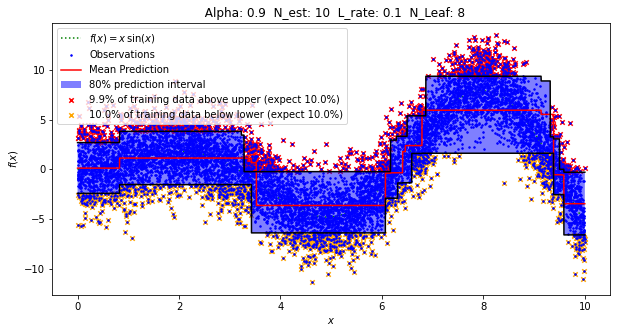

In [ ]:
plot_predictions(y, y_pred, y_upper, y_lower, y_autohigh, y_autolow)